In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients, distribute_data_per_client_edited
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from utils import Logger
from fid_score import *
from inception import *
import math

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True

In [4]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [5]:
NUM_WORKERS = 2
CLASSES_PER_USER = 7
NUM_EPOCHS = 200
BATCH_SIZE = 32

LEARNING_RATE = 2e-4
B1 = 0.5
B2 = 0.999


NOISE_DIM = 128
FID_BATCH_SIZE = 20
NUM_UNIQUE_USERS = NUM_WORKERS

In [6]:
num_classes = 10
dictionary = labels4clients(num_classes,CLASSES_PER_USER,NUM_WORKERS,NUM_UNIQUE_USERS,random_seed=False)
print(dictionary)

{0: [1], 1: [0, 1], 2: [0, 1], 3: [1], 4: [0], 5: [1], 6: [0, 1], 7: [0, 1], 8: [0], 9: [0]}


In [7]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans_cifar = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle = True,batch_size=10000)

MAX_WORKER_SAMPLE = len(dataset)/NUM_WORKERS

Files already downloaded and verified
Files already downloaded and verified


In [8]:
for img in dataloader_test:
    test_imgs=img[0].to(dev)

In [9]:
# print(dataset.data[0])
# print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
# print(dataset.transforms(dataset.data[0],trans_cifar))

transformed shape: (3, 32, 32)


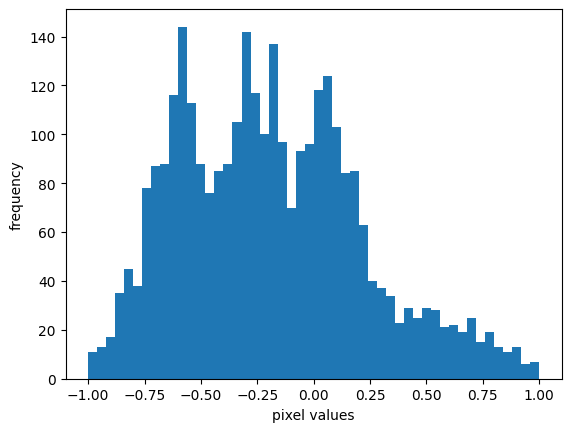

In [10]:
transformed = trans_cifar(dataset.data[0]).cpu().detach().numpy()
print("transformed shape:", transformed.shape)
plt.figure('normalized data')
plt.hist(transformed.ravel(), bins=50, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [11]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [12]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
print("train datatset shape:",x_train_normalized_np.shape)
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

train datatset shape: (50000, 3, 32, 32)


In [13]:
x_train_normalized_np[0][0].shape

(32, 32)

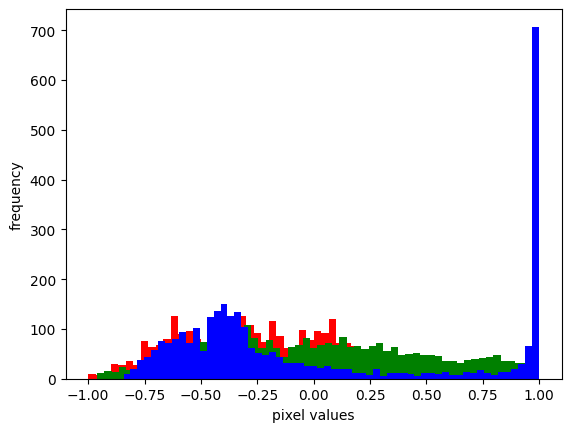

In [14]:
plt.figure('normalized data')
bin_size = 60
plt.hist(x_train_normalized_np[:][0].ravel(),color='r', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [15]:
# x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_clinet_list, y_client_list = distribute_data_per_client_edited(x_train_normalized_np,y_train,dictionary,CLASSES_PER_USER,random_seed = False, max_samples_per_client = MAX_WORKER_SAMPLE)

In [16]:
# def getDist(y,class_list,user_num):
#     ax = sns.countplot(x=y)
#     ax.set(title="Count of data classes for %s" %user_num)
#     plt.show()

In [17]:
def getDist(y,class_list,user_num):
    ax = sns.barplot(x=class_list,y=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

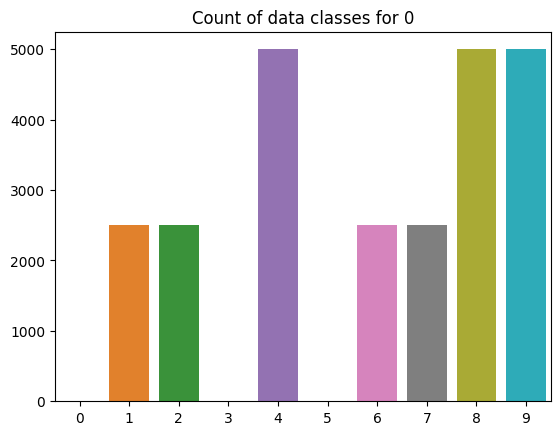

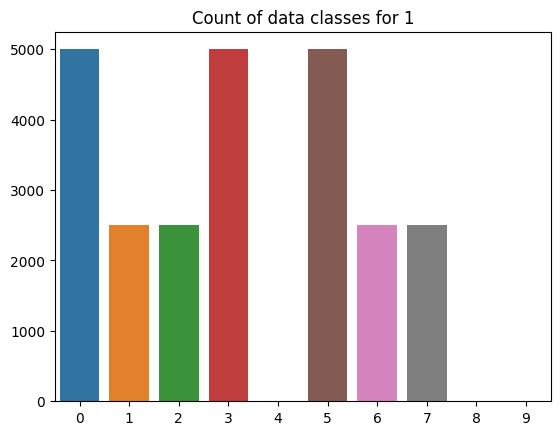

total used data 50000


In [18]:
total_data = 0
class_list = [i for i in range(num_classes)]
for i in range (len(x_clinet_list)):
    length = len(y_client_list[i])
    total_data+= length
    y_list = np.bincount(y_client_list[i],minlength=num_classes)
    getDist(y_list,class_list,i)
print("total used data", total_data)

In [19]:
fic_model = InceptionV3().to(dev)

In [20]:
main_server = Server(0,LEARNING_RATE,B1,B2,dev)
# initialize_weights(main_server.generator)
# initialize_weights(main_server.global_disc)
main_server.generator.train()
main_server.global_disc.train()
workers = []
workers_weights= []
for i in range(NUM_WORKERS):
    worker = Worker(i,LEARNING_RATE,B1,B2,dev)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    worker.load_worker_data(x_clinet_list[i], y_client_list[i]) 
    # initialize_weights(worker.discriminator)
    worker.discriminator.train()
    workers.append(worker)
    workers_weights.append(worker.discriminator.state_dict())
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [21]:
# # code to make all the workers the same
# workers_weights= []
# for worker in workers:
#     worker.discriminator = workers[-1].discriminator
#     workers_weights.append(worker.discriminator.state_dict())

In [22]:
criterion = nn.MSELoss()
fixed_noise = torch.randn(36, NOISE_DIM, 1, 1).to(dev) # to use for generating output images

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

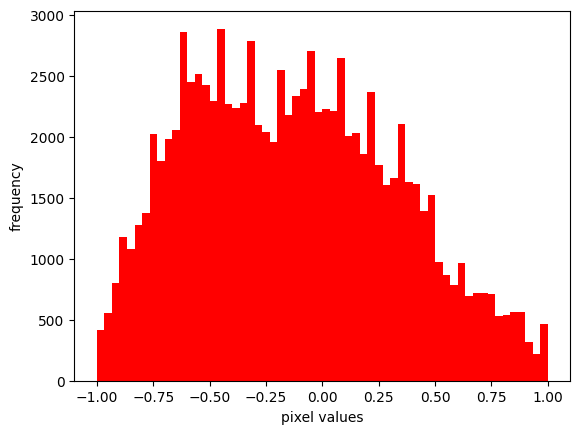

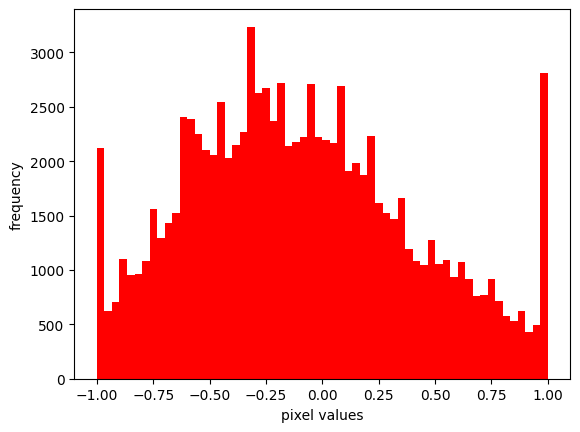

In [23]:
for worker in worker_loaders:
    plt.figure('normalized data')
    plt.hist(worker[:][1].ravel(),color='r', bins=bin_size, density=False)
    # plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
    # plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
    plt.xlabel("pixel values")
    plt.ylabel("frequency")
    plt.show()

In [24]:
logger = Logger(model_name='F2U',data_name='CIFAR10')

In [25]:
trial = False

In [26]:
# GAN archicture trial (trial == TRUE)
if trial:
    start = 0
    end = start + NUM_EPOCHS
    for epoch in range(start,end):
        for i, data in enumerate(dataloader_one):
            worker = workers[0]
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)
            real, _ = data

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            
            current_disc_real = worker.discriminator(real).reshape(-1)
            # print('current discriminator real output', current_disc_real)
            worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
            # print('worker loss_disc_real output', current_disc_real)
            current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
            worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
            worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
            worker.discriminator.zero_grad()
            worker.loss_disc.backward()
            # total_norm_d =0
            # for p in list(filter(lambda p: p.grad is not None, worker.discriminator.parameters())):
            #     total_norm_d += p.grad.detach().data.norm(2).item()** 2
            # total_norm_d = total_norm_d ** 0.5

            worker.d_optimizer.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            
            output = worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()

            # total_norm_g =0
            # for p in list(filter(lambda p: p.grad is not None, main_server.generator.parameters())):
            #     total_norm_g += p.grad.detach().data.norm(2).item()** 2
            # total_norm_g = total_norm_g ** 0.5

            main_server.g_optimizer.step()


            logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

            # Print loss
            if i % 100 == 0:    
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,i,len(dataloader_one))

                print(
                    f"Epoch [{epoch}/{end}] Batch {i}/{len(dataloader_one)} \
                    Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )

            if i% 500 == 0:
                with torch.no_grad():
                    fake = main_server.generator(fixed_noise)
                    logger.log_images(fake,len(fake), epoch, i, len(dataloader_one))
        if epoch % 50 == 0 and epoch !=0:
            logger.save_models(main_server,workers,epoch)


Epoch [40/200] Batch 0/782                     Loss D: 0.1542, loss G: 0.4101, FID Score: 234.4
Epoch [40/200] Batch 100/782                     Loss D: 0.1730, loss G: 0.4785, FID Score: 227.7
Epoch [40/200] Batch 200/782                     Loss D: 0.1892, loss G: 0.6207, FID Score: 230.2
Epoch [40/200] Batch 300/782                     Loss D: 0.1931, loss G: 0.4629, FID Score: 233.2
Epoch [40/200] Batch 400/782                     Loss D: 0.1963, loss G: 0.3638, FID Score: 237.9
Epoch [40/200] Batch 500/782                     Loss D: 0.2163, loss G: 0.9375, FID Score: 234.1
Epoch [40/200] Batch 600/782                     Loss D: 0.1872, loss G: 0.4947, FID Score: 243.7
Epoch [40/200] Batch 700/782                     Loss D: 0.1147, loss G: 0.9570, FID Score: 239.1


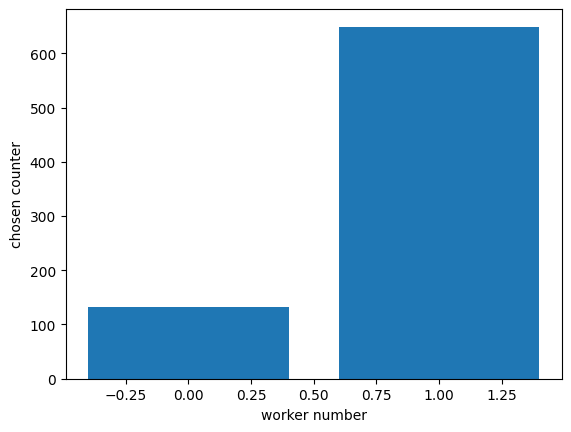

Epoch [41/200] Batch 0/782                     Loss D: 0.1537, loss G: 0.2866, FID Score: 239.4
Epoch [41/200] Batch 100/782                     Loss D: 0.0892, loss G: 0.8893, FID Score: 228.8
Epoch [41/200] Batch 200/782                     Loss D: 0.1918, loss G: 0.4405, FID Score: 235.4
Epoch [41/200] Batch 300/782                     Loss D: 0.2016, loss G: 0.5163, FID Score: 246.5
Epoch [41/200] Batch 400/782                     Loss D: 0.2032, loss G: 0.6299, FID Score: 229.1
Epoch [41/200] Batch 500/782                     Loss D: 0.1719, loss G: 0.6308, FID Score: 237.2
Epoch [41/200] Batch 600/782                     Loss D: 0.1907, loss G: 0.5109, FID Score: 233.6
Epoch [41/200] Batch 700/782                     Loss D: 0.1056, loss G: 1.1025, FID Score: 243.4
Epoch [42/200] Batch 0/782                     Loss D: 0.2122, loss G: 0.2473, FID Score: 230.6
Epoch [42/200] Batch 100/782                     Loss D: 0.1756, loss G: 0.5086, FID Score: 223.9
Epoch [42/200] Batch 200

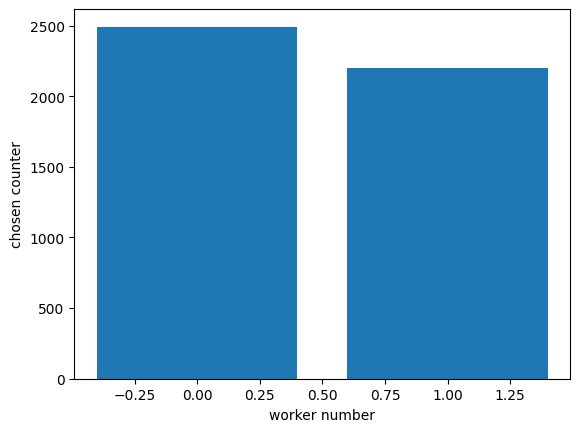

Epoch [46/200] Batch 0/782                     Loss D: 0.2429, loss G: 0.3654, FID Score: 231.6
Epoch [46/200] Batch 100/782                     Loss D: 0.1902, loss G: 0.3513, FID Score: 235.3
Epoch [46/200] Batch 200/782                     Loss D: 0.2171, loss G: 0.2761, FID Score: 240.3
Epoch [46/200] Batch 300/782                     Loss D: 0.2307, loss G: 0.4883, FID Score: 228.0
Epoch [46/200] Batch 400/782                     Loss D: 0.1987, loss G: 0.2465, FID Score: 216.5
Epoch [46/200] Batch 500/782                     Loss D: 0.2382, loss G: 0.2359, FID Score: 238.1
Epoch [46/200] Batch 600/782                     Loss D: 0.1944, loss G: 0.3835, FID Score: 215.6
Epoch [46/200] Batch 700/782                     Loss D: 0.2027, loss G: 0.3505, FID Score: 221.8
Epoch [47/200] Batch 0/782                     Loss D: 0.2387, loss G: 0.3399, FID Score: 219.5
Epoch [47/200] Batch 100/782                     Loss D: 0.0920, loss G: 0.6044, FID Score: 228.8
Epoch [47/200] Batch 200

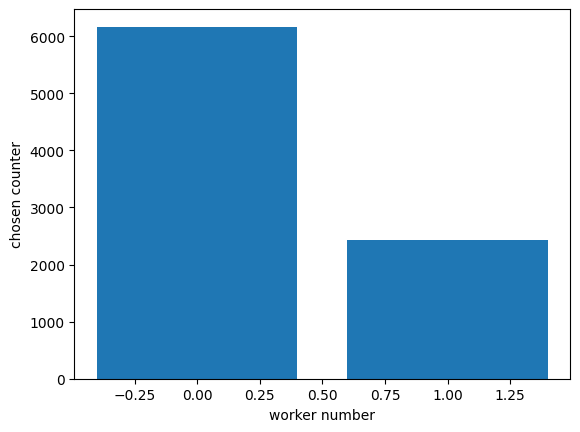

Epoch [51/200] Batch 0/782                     Loss D: 0.2292, loss G: 0.3045, FID Score: 224.6
Epoch [51/200] Batch 100/782                     Loss D: 0.2003, loss G: 0.4319, FID Score: 227.9
Epoch [51/200] Batch 200/782                     Loss D: 0.2192, loss G: 0.3141, FID Score: 233.5
Epoch [51/200] Batch 300/782                     Loss D: 0.2315, loss G: 0.3795, FID Score: 242.1
Epoch [51/200] Batch 400/782                     Loss D: 0.2079, loss G: 0.5269, FID Score: 235.2
Epoch [51/200] Batch 500/782                     Loss D: 0.2178, loss G: 0.3304, FID Score: 227.3
Epoch [51/200] Batch 600/782                     Loss D: 0.1803, loss G: 0.4645, FID Score: 235.7
Epoch [51/200] Batch 700/782                     Loss D: 0.2017, loss G: 0.3295, FID Score: 223.8
Epoch [52/200] Batch 0/782                     Loss D: 0.2243, loss G: 0.3246, FID Score: 226.1
Epoch [52/200] Batch 100/782                     Loss D: 0.1651, loss G: 0.4091, FID Score: 215.1
Epoch [52/200] Batch 200

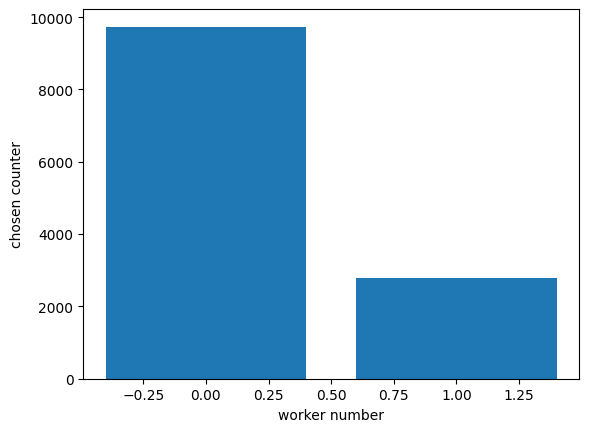

Epoch [56/200] Batch 0/782                     Loss D: 0.2629, loss G: 0.3162, FID Score: 236.0
Epoch [56/200] Batch 100/782                     Loss D: 0.1913, loss G: 0.4069, FID Score: 226.4
Epoch [56/200] Batch 200/782                     Loss D: 0.2126, loss G: 0.4112, FID Score: 240.4
Epoch [56/200] Batch 300/782                     Loss D: 0.2095, loss G: 0.3445, FID Score: 226.5
Epoch [56/200] Batch 400/782                     Loss D: 0.1761, loss G: 0.5489, FID Score: 236.6
Epoch [56/200] Batch 500/782                     Loss D: 0.2003, loss G: 0.4059, FID Score: 225.7
Epoch [56/200] Batch 600/782                     Loss D: 0.2002, loss G: 0.4429, FID Score: 230.1
Epoch [56/200] Batch 700/782                     Loss D: 0.1911, loss G: 0.4012, FID Score: 232.6
Epoch [57/200] Batch 0/782                     Loss D: 0.2764, loss G: 0.2833, FID Score: 212.9
Epoch [57/200] Batch 100/782                     Loss D: 0.1891, loss G: 0.4723, FID Score: 236.5
Epoch [57/200] Batch 200

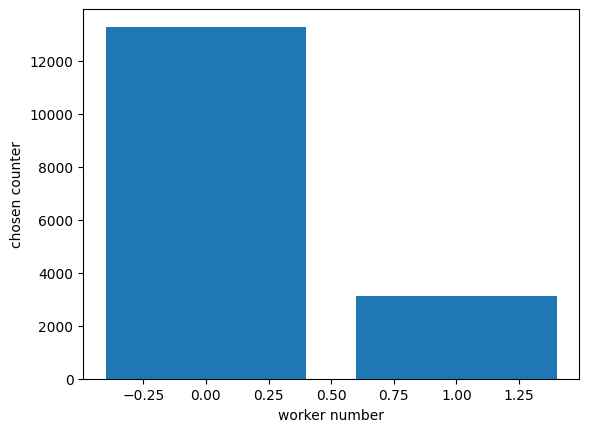

Epoch [61/200] Batch 0/782                     Loss D: 0.2920, loss G: 0.3446, FID Score: 227.2
Epoch [61/200] Batch 100/782                     Loss D: 0.1927, loss G: 0.5023, FID Score: 227.0
Epoch [61/200] Batch 200/782                     Loss D: 0.1949, loss G: 0.3515, FID Score: 223.8
Epoch [61/200] Batch 300/782                     Loss D: 0.2056, loss G: 0.4147, FID Score: 215.2
Epoch [61/200] Batch 400/782                     Loss D: 0.1898, loss G: 0.5287, FID Score: 235.1
Epoch [61/200] Batch 500/782                     Loss D: 0.2139, loss G: 0.4804, FID Score: 233.8
Epoch [61/200] Batch 600/782                     Loss D: 0.1929, loss G: 0.5076, FID Score: 220.9
Epoch [61/200] Batch 700/782                     Loss D: 0.1899, loss G: 0.3513, FID Score: 215.6
Epoch [62/200] Batch 0/782                     Loss D: 0.2489, loss G: 0.2950, FID Score: 217.5
Epoch [62/200] Batch 100/782                     Loss D: 0.1975, loss G: 0.3042, FID Score: 236.7
Epoch [62/200] Batch 200

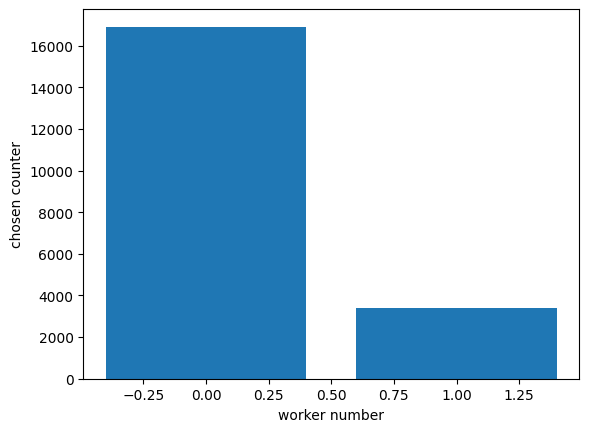

Epoch [66/200] Batch 0/782                     Loss D: 0.2377, loss G: 0.3538, FID Score: 225.7
Epoch [66/200] Batch 100/782                     Loss D: 0.2054, loss G: 0.3590, FID Score: 230.8
Epoch [66/200] Batch 200/782                     Loss D: 0.1925, loss G: 0.5460, FID Score: 223.7
Epoch [66/200] Batch 300/782                     Loss D: 0.2079, loss G: 0.4138, FID Score: 229.6
Epoch [66/200] Batch 400/782                     Loss D: 0.1693, loss G: 0.4295, FID Score: 217.0
Epoch [66/200] Batch 500/782                     Loss D: 0.2125, loss G: 0.3609, FID Score: 232.9
Epoch [66/200] Batch 600/782                     Loss D: 0.1795, loss G: 0.3992, FID Score: 222.8
Epoch [66/200] Batch 700/782                     Loss D: 0.2236, loss G: 0.3401, FID Score: 223.0
Epoch [67/200] Batch 0/782                     Loss D: 0.2605, loss G: 0.2785, FID Score: 228.0
Epoch [67/200] Batch 100/782                     Loss D: 0.1942, loss G: 0.4163, FID Score: 221.3
Epoch [67/200] Batch 200

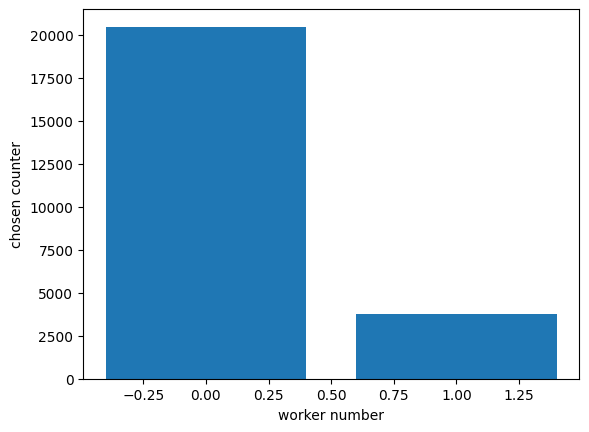

Epoch [71/200] Batch 0/782                     Loss D: 0.2625, loss G: 0.2334, FID Score: 229.4
Epoch [71/200] Batch 100/782                     Loss D: 0.2000, loss G: 0.3785, FID Score: 215.1
Epoch [71/200] Batch 200/782                     Loss D: 0.2217, loss G: 0.4642, FID Score: 226.8
Epoch [71/200] Batch 300/782                     Loss D: 0.1067, loss G: 0.7142, FID Score: 225.8
Epoch [71/200] Batch 400/782                     Loss D: 0.1045, loss G: 1.1309, FID Score: 237.4
Epoch [71/200] Batch 500/782                     Loss D: 0.2109, loss G: 0.3587, FID Score: 244.6
Epoch [71/200] Batch 600/782                     Loss D: 0.1979, loss G: 0.4714, FID Score: 230.6
Epoch [71/200] Batch 700/782                     Loss D: 0.2070, loss G: 0.4527, FID Score: 228.2
Epoch [72/200] Batch 0/782                     Loss D: 0.0963, loss G: 0.8809, FID Score: 223.6
Epoch [72/200] Batch 100/782                     Loss D: 0.1778, loss G: 0.3955, FID Score: 215.3
Epoch [72/200] Batch 200

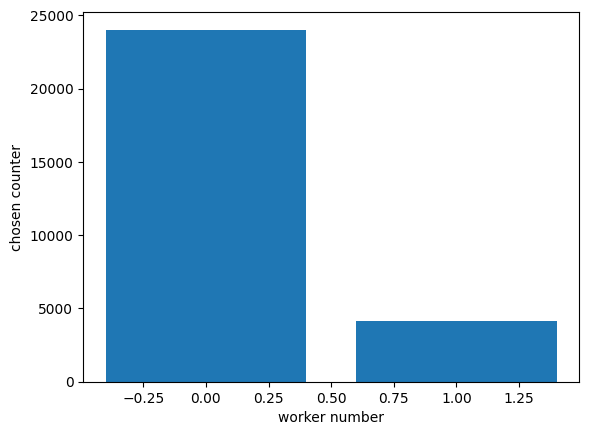

Epoch [76/200] Batch 0/782                     Loss D: 0.0595, loss G: 0.7225, FID Score: 234.8
Epoch [76/200] Batch 100/782                     Loss D: 0.0897, loss G: 0.8559, FID Score: 228.8
Epoch [76/200] Batch 200/782                     Loss D: 0.1888, loss G: 0.3682, FID Score: 226.0
Epoch [76/200] Batch 300/782                     Loss D: 0.0703, loss G: 0.9776, FID Score: 225.9
Epoch [76/200] Batch 400/782                     Loss D: 0.1730, loss G: 0.4018, FID Score: 213.1
Epoch [76/200] Batch 500/782                     Loss D: 0.2083, loss G: 0.4575, FID Score: 222.9
Epoch [76/200] Batch 600/782                     Loss D: 0.1609, loss G: 0.4606, FID Score: 229.7
Epoch [76/200] Batch 700/782                     Loss D: 0.2177, loss G: 0.3239, FID Score: 226.8
Epoch [77/200] Batch 0/782                     Loss D: 0.0674, loss G: 0.6747, FID Score: 230.8


In [28]:
# main training loop for F2U (trial == FALSE)
fed_avg = False
if not trial:
    start = 40
    end = start + NUM_EPOCHS
    end = NUM_EPOCHS
    worker_chosen_counter = [0 for i in range(len(workers))]

    for epoch in range(start,end):
        for batch_id in range(len(worker_loaders[0])):

            highest_loss = 0
            lowest_loss = math.inf
            chosen_discriminator = None
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)

            for worker_id, worker in enumerate(workers):
                current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)

                # print('worker ({}) datasum:'.format(worker_id),sum(current_worker_real.flatten()).item())
                # print(current_worker_real.shape)

                worker.d_optimizer.zero_grad()
            
                ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
                worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
                # print('real_classification:', round(sum(current_disc_real).item(),6),'real_loss:',round(worker.loss_disc_real.item(),6))
                current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
                worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
                # print('fake_classification:', round(sum(current_disc_fake).item(),6),'fake_loss:',round(worker.loss_disc_fake.item(),6))
                worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
                
                worker.loss_disc.backward()
                worker.d_optimizer.step()

                workers_weights[worker_id] = worker.discriminator.state_dict()
                # print(worker.loss_disc_fake, i)
                if highest_loss < worker.loss_disc_fake:
                    highest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
                # if lowest_loss > worker.loss_disc_fake:
                #     lowest_loss = worker.loss_disc_fake
                #     chosen_discriminator = worker_id
            # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
            
            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            chosen_worker = workers[chosen_discriminator]
            worker_chosen_counter[chosen_discriminator]+=1

            # worker_total_weights1 = []
            # for worker in workers:
            #     weight_sum = 0
            #     for i, p in enumerate(worker.discriminator.parameters()):
            #         output = sum(p.detach().cpu().numpy().flatten())
            #         weight_sum += output
            #     worker_total_weights1.append(round(weight_sum,1))

            main_server.g_optimizer.zero_grad()

            if fed_avg:
                avg_w = main_server.fed_average(workers_weights)
                main_server.global_disc.load_state_dict(avg_w)
                output = main_server.global_disc(fake).reshape(-1)
            else:
                output = chosen_worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            
            main_server.loss_gen.backward()
            # check weights of all workers before and after

            main_server.g_optimizer.step()

            # worker_total_weights2 = []
            # for worker in workers:
            #     weight_sum = 0
            #     for i, p in enumerate(worker.discriminator.parameters()):
            #         output = sum(p.detach().cpu().numpy().flatten())
            #         weight_sum += output
            #     worker_total_weights2.append(round(weight_sum,1))
            
            # diff = []
            # for i, curr_weight in enumerate(worker_total_weights2):
            #     diff.append(abs(curr_weight-worker_total_weights1[i]))
            # print("before g_optimizer:", worker_total_weights1, "after g_optimizer:", worker_total_weights2, "diff:", diff)

            with torch.no_grad():
                logger.log_workers(workers,epoch,batch_id,len(worker_loaders[0]))
                logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,batch_id,len(worker_loaders[0]))
            # Print loss
            if batch_id % 100 == 0:
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,batch_id,len(worker_loaders[0]))

                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                    Loss D: {chosen_worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )
            
        with torch.no_grad():
            main_server.generator.eval()
            fake = main_server.generator(fixed_noise)
            main_server.generator.train()
            logger.log_images(fake,len(fake), epoch, batch_id, len(worker_loaders[0]))

        if epoch % 5 == 0 and epoch != 0:
            plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
            plt.xlabel('worker number')
            plt.ylabel('chosen counter')
            plt.show()
        if epoch % 50 == 0 and epoch != 0 and not fed_avg:
            logger.save_models(main_server,workers,epoch)

In [ ]:
# plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
# plt.xlabel('worker number')
# plt.ylabel('chosen counter')
# plt.show()

In [ ]:
# for testing the total weights
# worker_total_weights1 = []
# for worker in workers:
#     weight_sum = 0
#     for i, p in enumerate(worker.discriminator.parameters()):
#         output = sum(p.detach().cpu().numpy().flatten())
#         weight_sum += output
#     worker_total_weights1.append(round(weight_sum,1))

# worker_total_weights2 = []
# for worker in workers:
#     weight_sum = 0
#     for i, p in enumerate(worker.discriminator.parameters()):
#         output = sum(p.detach().cpu().numpy().flatten())
#         weight_sum += output
#     worker_total_weights2.append(round(weight_sum,1))

# diff = []
# for i, curr_weight in enumerate(worker_total_weights2):
#     diff.append(abs(curr_weight-worker_total_weights1[i]))
# print("before g_optimizer:", worker_total_weights1, "after g_optimizer:", worker_total_weights2, "diff:", diff)
